In [1]:
# installing requirements from txt file
#pip install -r requirements.txt

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import yfinance as yf
from datetime import datetime
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, LayerNormalization, GlobalAveragePooling1D, Embedding
import seaborn as sns
import matplotlib.pyplot as plt

# **Step 1: Data retrieval and indicators calculation**

The idea is to consider a portfolio made only of SPY ETF, as it has been seen that holding an ETF which replicates the Standard and Poor 500 can be one of the best investments you can make.

In [2]:
# downloading monthly prices of the SPY ETF, as VIX data will be monthly and therefore we keep returns as monthly
spy_prices = yf.download('SPY', start = '2005-07-01', end = '2024-12-31', interval = '1mo', multi_level_index = False, auto_adjust = False) # starting since when we have availability for the VIX futures historical term structure
#if isinstance(spy_prices.columns, pd.MultiIndex):
    #spy_prices = spy_prices.xs(key="SPY", axis=1, level=1)
spy_prices = spy_prices['Adj Close'] # taking only adjusted close prices
spy_prices

[*********************100%***********************]  1 of 1 completed


Date
2005-07-01     85.602936
2005-08-01     84.800461
2005-09-01     85.118668
2005-10-01     83.459290
2005-11-01     87.127541
                 ...    
2024-08-01    560.071289
2024-09-01    570.086792
2024-10-01    566.732605
2024-11-01    600.528809
2024-12-01    584.114075
Name: Adj Close, Length: 234, dtype: float64

In [3]:
spy_rets = spy_prices.pct_change().dropna() # computing returns and dropping NAs (most importantly, dropping the first observation)
spy_rets.rename('SPY returns', inplace = True) # renaming the column as now we have returns and not prices
spy_rets

Date
2005-08-01   -0.009374
2005-09-01    0.003752
2005-10-01   -0.019495
2005-11-01    0.043953
2005-12-01   -0.007177
                ...   
2024-08-01    0.023365
2024-09-01    0.017883
2024-10-01   -0.005884
2024-11-01    0.059633
2024-12-01   -0.027334
Name: SPY returns, Length: 233, dtype: float64

Next, we upload VIX future (UX1 index) term structure data downloaded from Bloomberg as of January 2025, for the next months of 2025. The idea is to use this data for forecasting SPY returns for the year 2025 and, more in general, to predict scenarios of what will happen in the upcoming months and how our strategy works:

In [4]:
vix_data_ahead = pd.read_excel('VIX_term_structure_20250117.xlsx', header = 0) # uploading VIX futures ahead term structure data
vix_data_ahead = vix_data_ahead.drop(vix_data_ahead.index[0]) # removing first unnecessary row

for i in range(2, len(vix_data_ahead) + 1): # turning the Period column into datetime, needed for further analyses
    vix_data_ahead['Period'][i] = datetime.strptime(vix_data_ahead['Period'][i], '%m/%Y')
    
vix_data_ahead

C:\Users\Alessio Incelli\AppData\Local\Temp\ipykernel_27952\222383742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data_ahead['Period'][i] = datetime.strptime(vix_data_ahead['Period'][i], '%m/%Y')


,Tenor,Ticker,Period,Last Price,Days to expiration
1,Spot,VIX Index,Spot,15.9700,0.0
2,1M,UXF5 Index,2025-01-01 00:00:00,16.1792,30.0
3,1M,UXG5 Index,2025-02-01 00:00:00,17.2382,60.0
4,2M,UXH5 Index,2025-03-01 00:00:00,17.8351,90.0
5,3M,UXJ5 Index,2025-04-01 00:00:00,18.1962,120.0
6,4M,UXK5 Index,2025-05-01 00:00:00,18.4005,150.0
7,5M,UXM5 Index,2025-06-01 00:00:00,18.5484,180.0
8,6M,UXN5 Index,2025-07-01 00:00:00,18.8250,210.0
9,7M,UXQ5 Index,2025-08-01 00:00:00,18.8000,240.0
10,8M,UXU5 Index,2025-09-01 00:00:00,19.1000,270.0


In the table above, the Tenor column represents the maturity of each row of the term structure, ahead in time. The Ticker column gives information on which is the Bloomberg ticker used for the specific row, then a datetime version of the maturity follows in the Period column, together with price and days to expiration. We are basing our research as if we are at the beginning of January 2025 and we are going to be stuck there in time, as doing this in real time would be too computationally expensive.

In addition to that, we also upload the historical VIX futures term structure, as we will use this for training our model, together with historical past returns of the SPY. The process of uploading and data manipulation is exactly the same as for the ahead term structure data:

In [5]:
vix_data_hist = pd.read_excel('hist_vix_term_structure.xlsx', header = 0) # uploading VIX futures ahead term structure data
vix_data_hist = vix_data_hist.drop(vix_data_hist.index[0]) # removing first unnecessary row

for i in range(1, len(vix_data_hist) + 1): # turning the Period column into datetime, needed for further analyses
    vix_data_hist['Period'][i] = datetime.strptime(vix_data_hist['Period'][i], '%m/%Y')
    
vix_data_hist = vix_data_hist.sort_values(by = 'Period') # in the historical data, futures prices are not ordered properly in ascending or descending ordervix_data_hist
vix_data_hist

C:\Users\Alessio Incelli\AppData\Local\Temp\ipykernel_27952\2368633098.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data_hist['Period'][i] = datetime.strptime(vix_data_hist['Period'][i], '%m/%Y')


,Tenor,Ticker,Period,Last Price,Days past
166,5Y,UXG05 Index,2005-02-01 00:00:00,11.4800,7170.0
167,61M,UXH05 Index,2005-03-01 00:00:00,12.2200,7140.0
168,63M,UXK05 Index,2005-05-01 00:00:00,13.1600,7080.0
169,66M,UXQ05 Index,2005-08-01 00:00:00,14.4300,6990.0
162,6Y,UXG06 Index,2006-02-01 00:00:00,12.8700,6810.0
...,...,...,...,...,...
5,292M,UXM4 Index,2024-06-01 00:00:00,16.6821,210.0
6,293M,UXN4 Index,2024-07-01 00:00:00,17.1011,180.0
7,294M,UXQ4 Index,2024-08-01 00:00:00,17.3603,150.0
8,295M,UXU4 Index,2024-09-01 00:00:00,17.6000,120.0


Now we are going to define three functions which will be used to compute the indicators that are going to be part of the innovative strategy. The rolling volatility, rolling correlation and rate of change indicators will be used to double check that the switches between momentum and mean-reversion strategies make sense or to question them.

In [6]:
## creating functions for the three indicators which will compose the innovative part of our approach

def rolling_std(series, time_interval): # defining a function for volatility, which we consider as rolling standard deviation
    return series.rolling(window = time_interval).std()

def rolling_correlation(series1, series2, time_interval): # defining a function for the rolling correlation
    return series1.rolling(window = time_interval).corr(series2)

def ROC(series): # defining a function for the rate of change, that will be primarly used for the VIX slope
    return series.pct_change()

Furthermore, we are going to define a function that will create two new term structures, one for the historical one and the other for the ahead in time one, with newly calculated prices.
The prices will be calculated via linear interpolation with a targeted maturity, taken as the midpoint between two maturities, so that the new term structure is characterized by constant maturity.

In [7]:
def constant_mat_term_structure(vix_term_structure):
    """
    This function computes the linear interpolation of VIX futures prices 
    for generating a constant maturity term structure.
    
    It takes the VIX dataframe, be it either the historical one or the future one, as input,
    and will return the interpolated prices of the VIX futures.
    """
    
    constant_maturity_prices = [] # allocating memory for the prices computed with constant maturity approach
    for i in range(1, len(vix_term_structure)): # looping over all observations of the dataframe fed to the function
        maturity1 = vix_term_structure.loc[i - 1, "Days to expiration"] # first maturity
        maturity2 = vix_term_structure.loc[i, "Days to expiration"] # second maturity
        price1 = vix_term_structure.loc[i - 1, "Last Price"] # first price
        price2 = vix_term_structure.loc[i, "Last Price"] # second price
        
        target_maturity = (maturity1 + maturity2) / 2 # the target maturity is identified as the middle point between maturity 1 and 2
        
        # formula decided to be used for price interpolation
        interpolated_price = price1 * (maturity2 - target_maturity) / (maturity2 - maturity1) + price2 * (target_maturity - maturity1) / (maturity2 - maturity1)
        constant_maturity_prices.append(interpolated_price) # appending each result of the loop in the initially created variable
    
    constant_maturity_prices.insert(0, None) # adding NaN for the first row since it doesn't have a previous contract
    vix_term_structure["Constant Maturity Price"] = constant_maturity_prices # adding the newly computed prices to the original table
    return vix_term_structure

Running the function for both historical and 2025 VIX futures term structures:

In [8]:
vix_data_ahead = vix_data_ahead.reset_index(drop = True) # resetting the index of the ahead term structure for data manipulation
constant_maturity_ahead = constant_mat_term_structure(vix_data_ahead) # computing constant maturity ahead term structure

vix_data_hist = vix_data_hist.reset_index(drop = True) # resetting the index of the ahead term structure for data manipulation
vix_data_hist.rename(columns = {'Days past': 'Days to expiration'}, inplace = True) # column renaming for data manipulation (the function admits 'Days to expiration', we could have changed the function but it would require more than one line as here)
constant_maturity_hist = constant_mat_term_structure(vix_data_hist) # computing constant maturity historical term structure
vix_data_hist.rename(columns = {'Days to expiration': 'Days past'}, inplace = True) # column renaming for data manipulation (the function admits 'Days to expiration', we could have changed the function but it would require more than one line as here)

In [9]:
print("Constant Maturity Term Structure ahead:") # printing the new ahead term structure, made of prices at constant maturity
constant_maturity_ahead[['Period', 'Constant Maturity Price']]

Constant Maturity Term Structure ahead:


,Period,Constant Maturity Price
0,Spot,NaN
1,2025-01-01 00:00:00,16.07460
2,2025-02-01 00:00:00,16.70870
3,2025-03-01 00:00:00,17.53665
4,2025-04-01 00:00:00,18.01565
5,2025-05-01 00:00:00,18.29835
6,2025-06-01 00:00:00,18.47445
7,2025-07-01 00:00:00,18.68670
8,2025-08-01 00:00:00,18.81250
9,2025-09-01 00:00:00,18.95000


In [10]:
print("Constant Maturity Term Structure historical:") # printing the new historical term structure, made of prices at constant maturity
constant_maturity_hist[['Period', 'Constant Maturity Price']]

Constant Maturity Term Structure historical:


,Period,Constant Maturity Price
0,2005-02-01 00:00:00,NaN
1,2005-03-01 00:00:00,11.85000
2,2005-05-01 00:00:00,12.69000
3,2005-08-01 00:00:00,13.79500
4,2006-02-01 00:00:00,13.65000
...,...,...
164,2024-06-01 00:00:00,16.51625
165,2024-07-01 00:00:00,16.89160
166,2024-08-01 00:00:00,17.23070
167,2024-09-01 00:00:00,17.48015


If one compares the two term structures just obtained with the previous versions originally uploaded here, not at constant maturity, then it can be observed that the interpolated prices and the original prices are not so distant from each other.

Calculating the slope of the constant maturity VIX futures term structure in a normalized way, meaning with the difference in prices at the numerator and the difference in days at the denominator:

In [11]:
# computing the slope of the ahead term structure
constant_maturity_ahead['vix_slope'] = constant_maturity_ahead["Constant Maturity Price"].diff() / constant_maturity_ahead["Days to expiration"].diff()
constant_maturity_ahead['vix_slope']

0         NaN
1         NaN
2    0.021137
3    0.027598
4    0.015967
5    0.009423
6    0.005870
7    0.007075
8    0.004193
9    0.004583
Name: vix_slope, dtype: float64

Applying the same to the historical constant maturity term structure (to evaluate if a negative sign is needed in front of this):

In [14]:
# computing the slope of the historical term structure
constant_maturity_hist["vix_slope"] = constant_maturity_hist["Constant Maturity Price"].diff() / constant_maturity_hist["Days past"].diff() # maybe a negative sign in front of it?
constant_maturity_hist["vix_slope"]

0           NaN
1           NaN
2     -0.014000
3     -0.012278
4      0.000806
         ...   
164   -0.013038
165   -0.012512
166   -0.011303
167   -0.008315
168   -0.052328
Name: vix_slope, Length: 169, dtype: float64

An initial calculation of the three indicators follows. In order to compute the rolling correlation between the slope of the VIX futures term structure, we are going to combine that data with the SPY returns in a unique dataframe for ease of computation.

In [15]:
# now the idea is to merge the historical VIX dataframe with returns from SPY, so that we have aligned data and we can compute correlation
constant_maturity_hist = constant_maturity_hist.set_index('Period', drop = True) # setting the dates as index
correlation_dataset = constant_maturity_hist.join(spy_rets, how = 'left') # adding the returns from SPY to the historical VIX dataframe
correlation_dataset = correlation_dataset.drop(['Tenor', 'Ticker', 'Last Price', 'Days past', 'Constant Maturity Price'], axis = 1) # dropping unnecessary columns for correlation analysis

correlation_dataset

,vix_slope,SPY returns
Period,,
2005-02-01,NaN,NaN
2005-03-01,NaN,NaN
2005-05-01,-0.014000,NaN
2005-08-01,-0.012278,-0.009374
2006-02-01,0.000806,0.005725
...,...,...
2024-06-01,-0.013038,0.031951
2024-07-01,-0.012512,0.015374
2024-08-01,-0.011303,0.023365


Using the previously defined three functions, we are computing the innovative indicators that we are going to use as a double check after the momentum transformer:

In [16]:
vol_indicator = rolling_std(spy_rets, time_interval = 5).dropna() # calculating volatility indicator on the returns of SPY
correlation_indicator = rolling_correlation(correlation_dataset['vix_slope'], correlation_dataset['SPY returns'], time_interval = 5).dropna() # computing correlation indicator between SPY returns and historical VIX slope
roc_indicator = ROC(correlation_dataset['vix_slope']).dropna() # calculating rate of change of the historical VIX futures constant maturity term structure slope
roc_indicator.replace([np.inf, -np.inf], np.nan, inplace = True) # replacing infinite values with nan, as there are a couple of zeros in the slope columns which generate inf
roc_indicator.dropna(inplace = True) # dropping again rows with nan values

In [17]:
print("Historical rolling volatility indicator:")
print(vol_indicator)

Historical rolling volatility indicator:
Date
2005-12-01    0.024689
2006-01-01    0.026147
2006-02-01    0.026042
2006-03-01    0.020083
2006-04-01    0.013524
                ...   
2024-08-01    0.032965
2024-09-01    0.014218
2024-10-01    0.014054
2024-11-01    0.023751
2024-12-01    0.032741
Name: SPY returns, Length: 229, dtype: float64


In [18]:
print("Historical rolling correlation indicator:")
print(correlation_indicator)

Historical rolling correlation indicator:
Period
2006-08-01    0.411574
2007-02-01    0.156484
2007-03-01    0.276872
2007-04-01   -0.271608
2007-05-01   -0.628527
                ...   
2024-06-01    0.292605
2024-07-01    0.264485
2024-08-01    0.620177
2024-09-01   -0.911279
2024-10-01    0.866637
Length: 162, dtype: float64


In [19]:
print("Historical VIX slope rate of change indicator:")
print(roc_indicator)

Historical VIX slope rate of change indicator:
Period
2005-08-01    -0.123016
2006-02-01    -1.065611
2006-03-01    25.068966
2006-05-01    -1.690476
2006-08-01    -0.022989
                ...    
2024-06-01    -0.420519
2024-07-01    -0.040394
2024-08-01    -0.096577
2024-09-01    -0.264376
2024-10-01     5.293245
Name: vix_slope, Length: 163, dtype: float64


# **Step 2: Training the Momentum Transformer model**

## **2.1: Double LSTM approach**

In order to train the momentum transformer model, we take the correlation_dataset dataframe created above, because it contains everything we need for the model training: namely, our x variable is the slope of the historical VIX futures term structure data, while our y variable is represented by the SPY returns.

In [20]:
correlation_dataset = correlation_dataset.dropna() # dropping the first NAs due to rolling window
spy_rets_training = correlation_dataset['SPY returns'] # identifying the historical SPY returns for training
vix_slope_training = correlation_dataset['vix_slope'] # identifying the historical VIX slope for training

Computing the three indicators for the training part:

In [21]:
vol_indicator_training = rolling_std(spy_rets_training, time_interval = 5).dropna() # computing volatility indicator for the training part
correlation_indicator_training = rolling_correlation(spy_rets_training, vix_slope_training, time_interval = 5).dropna() # computing correlation indicator for the training part
roc_indicator_training = ROC(vix_slope_training).dropna() # computing roc indicator for the training part
roc_indicator_training.replace([np.inf, -np.inf], np.nan, inplace = True) # replacing infinite values with nan, as there are a couple of zeros in the slope columns which generate inf
roc_indicator_training.dropna(inplace = True) # dropping again rows with nan values

Momentum transformer has become quite famous in this area of research because RNNs and LSTM approaches generate vanishing or exploding gradients. Therefore, we are first exploring what happens with LSTM, before moving on to the momentum transformer approach.

Combining the two variables in a proper dataframe, which is called also differently, so that it is clear that now we are starting to group the data.

In [22]:
## first, we are going to check results with a double LSTM, as normally momentum transformer replaces LSTM because of vanishing gradients
doubleLSTM_train_data = pd.DataFrame({ # combining historical vix slope and SPY returns data for training
    'Historical VIX futures slope': vix_slope_training,
    'Stock Returns': spy_rets_training
}).dropna()

doubleLSTM_train_data

,Historical VIX futures slope,Stock Returns
Period,,
2005-08-01,-0.012278,-0.009374
2006-02-01,0.000806,0.005725
2006-03-01,0.021000,0.012478
2006-05-01,-0.014500,-0.030122
2006-08-01,-0.014167,0.021823
...,...,...
2024-06-01,-0.013038,0.031951
2024-07-01,-0.012512,0.015374
2024-08-01,-0.011303,0.023365


Moving on, we are going to use StandardScaler to standardize the two variables that are going to be part of the model. In addition to this, we are also feeding to the model the vix slope variable in sequence: instead of providing the data as it is, we are providing sequences of the time series data, so that the model tries to understand the trends in the data over the specified length of the sequence. The idea is that, this way, the model will try to learn the data not taking each data point individually but rather trying to understand the temporal dependencies.
In our case, if the length of the sequence is equal to 5, it means the model is learning with sequences of 5-months data. Given this, the length of the sequence can be considered as a hyperparameter and we are going to explore also other possible options.

In [23]:
scaler_doubleLSTM = StandardScaler() # activating the scaler for standardizing the two variables
scaled_features_doubleLSTM = scaler_doubleLSTM.fit_transform(doubleLSTM_train_data) # standardizing

X_doubleLSTM, y_doubleLSTM = [], [] # pre-allocating memory for appending standardized values
sequence_length = 5 # instead of considering single data points, deciding for the length of a sequence of consecutive observations to fed the model with, in order to try to capture temporal dependencies

for i in range(sequence_length, len(scaled_features_doubleLSTM)): # appending
    X_doubleLSTM.append(scaled_features_doubleLSTM[i-sequence_length:i]) # TAKE VIX_SLOPE AND NOT SCALED_FEATURES???
    y_doubleLSTM.append(spy_rets_training.iloc[i])

X_doubleLSTM = np.array(X_doubleLSTM) # turning the list into a numpy array
y_doubleLSTM = np.array(y_doubleLSTM) # turning the list into a numpy array

Splitting the two variables into a training and a testing part, for now considering an 80/20 split.

In [24]:
X_train_doubleLSTM, X_test_doubleLSTM, y_train_doubleLSTM, y_test_doubleLSTM = train_test_split(
    X_doubleLSTM, y_doubleLSTM, test_size = 0.2, random_state = 42
) # training-testing dataframes split, for now going with 80/20

Once the dataframes are prepared, it's time to define the approach we are going to use, and to actually run it to fit it on the training part of the model. We decided to opt for a sequential object with two LSTM: the first one with 64 hidden neurons to initially learn from the data and then a second LSTM, with 32 hidden neurons, to redefine the knowledge in a less complex way. 
Sigmoid activation function is used (we are exploring the possibility to change it to classification), Adam is the chosen optimizer and the mean squared error was selected as a loss measure.

In [25]:
doubleLSTM_model = Sequential([ # grouping layers into a model with Sequential, so that we have one output for each input in a layer
    LSTM(64, input_shape = (X_doubleLSTM.shape[1], X_doubleLSTM.shape[2]), return_sequences = True), # first Long-Short Term Memory approach
    Dropout(0.2), # first dropout rate
    LSTM(32, return_sequences = False), # second Long-Short Term Memory approach
    Dropout(0.2), # second dropout rate
    Dense(1, activation = 'sigmoid') # the output is a single value, try to see what happens if you change sigmoid with classification
])

doubleLSTM_model.compile(optimizer = 'adam', loss = 'mean_squared_error') # compiling with adam optimizer and mean-squared error loss
res = doubleLSTM_model.fit(X_train_doubleLSTM, y_train_doubleLSTM, # fitting the model on the testing part of the dataframes
                            epochs = 20, batch_size = 16, 
                            validation_data = (X_test_doubleLSTM, y_test_doubleLSTM)) # validation part (IS THIS REALLY NEEDED HERE?)

C:\Users\Alessio Incelli\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.2392 - val_loss: 0.2259
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2154 - val_loss: 0.1962
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1810 - val_loss: 0.1454
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1248 - val_loss: 0.0675
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0475 - val_loss: 0.0105
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0070 - val_loss: 0.0027
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020 - val_loss: 0.0024


Extracting forecasts and calculating the mean squared error between them and the actually testing part of the SPY returns:

In [26]:
forecasts_doubleLSTM = doubleLSTM_model.predict(X_test_doubleLSTM) # we can eventually check the forecasts on the testing part of the x variables
rmse_doubleLSTM = np.sqrt(mean_squared_error(y_test_doubleLSTM, forecasts_doubleLSTM)) # calculating root mean squared error as error measure between testing part of returns and forecasts
print("Double LSTM RMSE:", rmse_doubleLSTM)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step
Double LSTM RMSE: 0.04846384502015212


The MSE value obtained is around 0.048, which is a small enough value to state that the forecasts of the SPY returns seem to be accurate.

## **2.2: Momentum transformer**

In [27]:
## building the proper Momentum Transformer model
spy_rets_training = correlation_dataset['SPY returns'] # identifying the historical SPY returns for training
vix_slope_training = correlation_dataset['vix_slope'] # identifying the historical VIX slope for training

In [28]:
class transformer_core(Layer): # main class for the transformer model
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
        super(transformer_core, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim) # applying self-attention mechanism over the input sequence
        self.ffn = tf.keras.Sequential([ # after self-attention mechanism, two dense layers are used to process each token in an isolated way
            Dense(ff_dim, activation = 'relu'), # ReLu activation function  
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon = 1e-6) # the input is normalized so that the training is faster and more stable
        self.layernorm2 = LayerNormalization(epsilon = 1e-6) # done for both layers
        self.dropout1 = Dropout(rate) # first dropout rate
        self.dropout2 = Dropout(rate) # second dropout rate

    def call(self, inputs, training): # here we define a class for designing how the input is fed to the layers
        attn_output = self.att(inputs, inputs) # self-attention
        attn_output = self.dropout1(attn_output, training = training) # the dropout makes the neurons alive in a random fashion
        out1 = self.layernorm1(inputs + attn_output) # as well as inputs, here we normalize the output
        ffn_output = self.ffn(out1) # transforming the normalized output
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

In [29]:
class positionalencoding(Layer): # defining another class for the positional encoding step of the transformer
    def __init__(self, sequence_length, embed_dim):
        super(positionalencoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, embed_dim) # the positional encoding will learn temporal dependencies with the length of sequence for input data that we decided

    def get_angles(self, pos, i, d_model): # defining a function to calculate sin and cosin of the angle
        angle_degree = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_degree

    def positional_encoding(self, position, d_model): # here we define a function for proper positional encoding, which takes as inputs the maximum length of a sequence (position) and the dimension of each embedding (d_model)
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], # creating an array of integers showing the positions in the sequence
                                     np.arange(d_model)[np.newaxis, :], # creating an array for the dimensions of the embeddings
                                     d_model) 
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2]) # applying the sine function to all columns with an even number
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2]) # applying the cosine function to all columns with an odd number
        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs): # defining a function to add everything built in the positional encoding to the initial input data
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [30]:
def momentum_transformer(sequence_length, feature_dim): # defining a function for a transformer based neural network, that takes as inputs the window size and the features
    embed_dim = 32  # setting the size of embedding dimensions for each token
    num_heads = 4  # setting the number of heads in the multi-head attention mechanism
    ff_dim = 128  # setting the number of hidden neurons for the feed forward network
    inputs = Input(shape = (sequence_length, feature_dim)) # storing memory for input data, where the shape is given by the length of each sequence and the feature dimension
    x = Dense(embed_dim)(inputs) # fully connected (dense) layer is applied to transform the input features into a higher-dimensional space of size given by the embedding dimension
    x = positionalencoding(sequence_length, embed_dim)(x) # applying positional encoding to the inputs
    x = transformer_core(embed_dim, num_heads, ff_dim)(x, training = True) # launching the core transformer class
    x = GlobalAveragePooling1D()(x) # computing the mean across for all points in time for future dimension, after this the sequence becomes a single vector
    x = Dropout(0.1)(x) # applying dropout, here with a probability of 10% to prevent overfitting (it means that 10% of the elements in x are being put equal to zero)
    x = Dense(20, activation = 'relu')(x) # applying a dense layer with 20 neurons and ReLu activation function
    x = Dropout(0.1)(x) # a second dropout rate is applied, again 10%
    outputs = Dense(1, activation = 'sigmoid')(x) # the last dense layer for output is applied with 1 neuron and sigmoid activation function
    model = Model(inputs = inputs, outputs = outputs) # creating a model object, using the defined inputs and outputs
    model.compile(optimizer = 'adam', loss = 'mean_squared_error') # compiling the model, using adam optimizer and mean squared error as a loss measure, also to compare with double LSTM approach
    return model

In [31]:
sequence_length = 5 # the length of the sequence is set the same as for double LSTM approach
scaler_transformer = StandardScaler() # activating standard scaler
transformed_data = scaler_transformer.fit_transform(pd.DataFrame({ # grouping the vix slope and spy rets data together, as before
    'Historical VIX futures slope': vix_slope_training,
    'Stock Returns': spy_rets_training
}).dropna()) # dropping NAs

In [32]:
X_transformer, y_transformer = [], [] # as before, pre-allocating memory for x and y dataframes
for i in range(sequence_length, len(transformed_data)): # as before, appending data using the length of sequence
    X_transformer.append(transformed_data[i-sequence_length:i])
    y_transformer.append(spy_rets_training.iloc[i])

X_transformer = np.array(X_transformer) # turning into a numpy array
y_transformer = np.array(y_transformer) # turning into a numpy array

In [33]:
X_train_transformer, X_test_transformer, y_train_transformer, y_test_transformer = train_test_split(
    X_transformer, y_transformer, test_size = 0.2, random_state = 42) # same type of split

transformer_model = momentum_transformer(sequence_length, X_transformer.shape[2]) # running the momentum transformer model
transformer_model.fit(X_train_transformer, y_train_transformer, epochs = 20, batch_size = 16, validation_data = (X_test_transformer, y_test_transformer)) # fitting the momentum transformer on training data and validating


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.1455 - val_loss: 0.0061
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0104 - val_loss: 0.0031
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021 - val_loss: 0.0023


In [34]:
forecasts_transformer = transformer_model.predict(X_test_transformer) # predicting forecasts using testing data of the vix slopeforecasts_transformer
forecasts_transformer

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step


array([[0.00341543],
       [0.00348032],
       [0.00414725],
       [0.00378472],
       [0.00370054],
       [0.00365845],
       [0.00452455],
       [0.00378829],
       [0.00455904],
       [0.0041908 ],
       [0.00614561],
       [0.00351433],
       [0.00356073],
       [0.00337183],
       [0.00368025],
       [0.00367735],
       [0.00455595],
       [0.00355692],
       [0.00370766],
       [0.00362092],
       [0.00349126],
       [0.00430847],
       [0.00444773],
       [0.00382269],
       [0.00391815],
       [0.00373875],
       [0.00352538],
       [0.00381887],
       [0.00360026],
       [0.00355737],
       [0.00373017],
       [0.00367052],
       [0.00367165]], dtype=float32)

In [35]:
rmse_transformer = np.sqrt(mean_squared_error(y_test_transformer, forecasts_transformer)) # computing mean-squared error
print("Transformer RMSE:", rmse_transformer)

Transformer RMSE: 0.048526478880318816


# **Step 3: Using trained model for forecasting 2025 scenarios**

As of now, given that it is impossible to have true values of SPY returns for the 2025 as they still don't exist, instead of setting up another machine learning/deep learning model to forecast them, our proposal is to use the estimates of SPY prices, for the whole 2025, provided by the Economy Forecast Agency (EFA). Their website is the following: https://usdforecast.com/ , and the specific estimates we are taking are here:  https://longforecast.com/spy-stock

In [37]:
spy_prices_pred_2025 = pd.read_excel('spy_pred_2025.xlsx') # uploading predicted prices of SPY for 2025
spy_prices_pred_2025 = spy_prices_pred_2025[['Month', 'Close']] # taking only the month and the close prices
spy_prices_pred_2025 = spy_prices_pred_2025[:-3] # removing October, November and December 2025 to align with VIX futures data
spy_prices_pred_2025

,Month,Close
0,Feb,603
1,Mar,605
2,Apr,621
3,May,604
4,Jun,637
5,Jul,640
6,Aug,646
7,Sep,679


In [38]:
forward_vix_slope = constant_maturity_ahead[['Period', 'vix_slope']] # storing the ahead vix slope in a new variable
forward_vix_slope = forward_vix_slope.dropna().reset_index(drop = True) # dropping NAs and resetting index as it does not start from 0forward_vix_slope
forward_vix_slope

,Period,vix_slope
0,2025-02-01 00:00:00,0.021137
1,2025-03-01 00:00:00,0.027598
2,2025-04-01 00:00:00,0.015967
3,2025-05-01 00:00:00,0.009423
4,2025-06-01 00:00:00,0.005870
5,2025-07-01 00:00:00,0.007075
6,2025-08-01 00:00:00,0.004193
7,2025-09-01 00:00:00,0.004583


In [39]:
transformer_data = pd.DataFrame({ # grouping the vix slope and spy rets data together, as before
    '2025 VIX futures slope': forward_vix_slope['vix_slope'],
    'Stock Returns': spy_prices_pred_2025['Close']
}).dropna() # dropping NAs

transformer_data = np.array(transformer_data) # turning the dataframe into a numpy array, as it is needed by the transformer model
transformer_data

array([[2.11366667e-02, 6.03000000e+02],
       [2.75983333e-02, 6.05000000e+02],
       [1.59666667e-02, 6.21000000e+02],
       [9.42333333e-03, 6.04000000e+02],
       [5.87000000e-03, 6.37000000e+02],
       [7.07500000e-03, 6.40000000e+02],
       [4.19333333e-03, 6.46000000e+02],
       [4.58333333e-03, 6.79000000e+02]])

In [40]:
# now the vix slope variable needs to be transformed into an array of shape similar to the one used for train
# therefore I am setting the final parameters I want:
num_obs = 8 # Number of observations (because we have 8 observations for the 2025 forward VIX futures slope)
timesteps = 5 # sequence used to train the model
features = 2 # variables 

transformer_expanded_data = np.zeros((num_obs, timesteps, features))# storing memory for the expanded data

for i in range(num_obs): # expanding the data repeating values but making sure that each value appears at least once
    for t in range(timesteps):
        transformer_expanded_data[i, t] = transformer_data[(i + t) % num_obs]

transformer_expanded_data

array([[[2.11366667e-02, 6.03000000e+02],
        [2.75983333e-02, 6.05000000e+02],
        [1.59666667e-02, 6.21000000e+02],
        [9.42333333e-03, 6.04000000e+02],
        [5.87000000e-03, 6.37000000e+02]],

       [[2.75983333e-02, 6.05000000e+02],
        [1.59666667e-02, 6.21000000e+02],
        [9.42333333e-03, 6.04000000e+02],
        [5.87000000e-03, 6.37000000e+02],
        [7.07500000e-03, 6.40000000e+02]],

       [[1.59666667e-02, 6.21000000e+02],
        [9.42333333e-03, 6.04000000e+02],
        [5.87000000e-03, 6.37000000e+02],
        [7.07500000e-03, 6.40000000e+02],
        [4.19333333e-03, 6.46000000e+02]],

       [[9.42333333e-03, 6.04000000e+02],
        [5.87000000e-03, 6.37000000e+02],
        [7.07500000e-03, 6.40000000e+02],
        [4.19333333e-03, 6.46000000e+02],
        [4.58333333e-03, 6.79000000e+02]],

       [[5.87000000e-03, 6.37000000e+02],
        [7.07500000e-03, 6.40000000e+02],
        [4.19333333e-03, 6.46000000e+02],
        [4.58333333e-03, 6

In [41]:
initial_mom_prob = transformer_model.predict(transformer_expanded_data).flatten() # creating initial momentum probabilities using the trained transformer model
initial_mom_prob

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([0.07278819, 0.07308782, 0.07329683, 0.07263068, 0.07260047,
       0.07216654, 0.07195894, 0.07149825], dtype=float32)

In [42]:
def momentum_signal(vix_slope): # defining a function for the momentum signal
    return np.sign(vix_slope)  # momentum signal is activated when VIX future slope is decreasing (contango steepening)

def mean_reversion_signal(stock_returns): # defining a function for the mean reversion signal
    return -np.sign(stock_returns)  # mean reversion signal is activated when returns are extreme

In [43]:
# generating trading signals
momentum_component = initial_mom_prob * momentum_signal(forward_vix_slope['vix_slope']) # momentum signals are given by the momentum probabilities multiplied by whether the vix slope gives us momentum vibes
mean_reversion_component = (1 - initial_mom_prob) * mean_reversion_signal(spy_prices_pred_2025['Close'].pct_change()) # mean reversion signals are given by the momentum probabilities multiplied by whether the returns give us mean reversion vibes
trading_signal = momentum_component + mean_reversion_component # summing

strategy_type = np.where(momentum_component > mean_reversion_component, "Momentum", "Mean Reversion") # showing the active strategy at each time step
strategy_type

array(['Mean Reversion', 'Momentum', 'Momentum', 'Mean Reversion',
       'Momentum', 'Momentum', 'Momentum', 'Momentum'], dtype='<U14')

In [44]:
def backtest_trading_signals(signals, stock_prices, initial_capital = 1000): # function for an initial backtest with a simulated initial capital of 1,000 euro
    monthly_returns = stock_prices.pct_change().fillna(0) # monthly returns are calculated as percentage difference
    #strategy_returns = signals * daily_returns
    strategy_returns = signals.shift(1).fillna(0) * monthly_returns  # shift to avoid lookahead bias
    cumulative_returns = (1 + strategy_returns).cumprod() # cumulative multiplication of returns
    portfolio_value = initial_capital * cumulative_returns  # portfolio evolution over time
    return portfolio_value, strategy_returns

# running backtest on the trading signal previously generated and the spy predicted prices for 2025
portfolio_value, strategy_returns = backtest_trading_signals(pd.Series(trading_signal, index = spy_prices_pred_2025.index), 
                                                              spy_prices_pred_2025['Close'])

In [45]:
results_df = pd.DataFrame({ # grouping everything into a dataframe to show strategy switches and returns
    'Date': forward_vix_slope['Period'], # we take the months from the forward vix slope dataframe
    'SPY Price': spy_prices_pred_2025['Close'], # SPY prices forecasted for 2025
    'VIX Slope': forward_vix_slope['vix_slope'], # forward VIX futures term structure slope
    'Trading Signal': trading_signal, # trading signal previously generated
    'Active Strategy': strategy_type, # switches between momentum and mean reversion
    'Daily Strategy Return': strategy_returns
})
results_df.set_index('Date', inplace = True)
results_df

,SPY Price,VIX Slope,Trading Signal,Active Strategy,Daily Strategy Return
Date,,,,,
2025-02-01,603,0.021137,NaN,Mean Reversion,0.000000
2025-03-01,605,0.027598,-0.853824,Momentum,0.000000
2025-04-01,621,0.015967,-0.853406,Momentum,-0.022580
2025-05-01,604,0.009423,1.000000,Mean Reversion,0.023362
2025-06-01,637,0.005870,-0.854799,Momentum,0.054636
2025-07-01,640,0.007075,-0.855667,Momentum,-0.004026
2025-08-01,646,0.004193,-0.856082,Momentum,-0.008022
2025-09-01,679,0.004583,-0.857003,Momentum,-0.043732


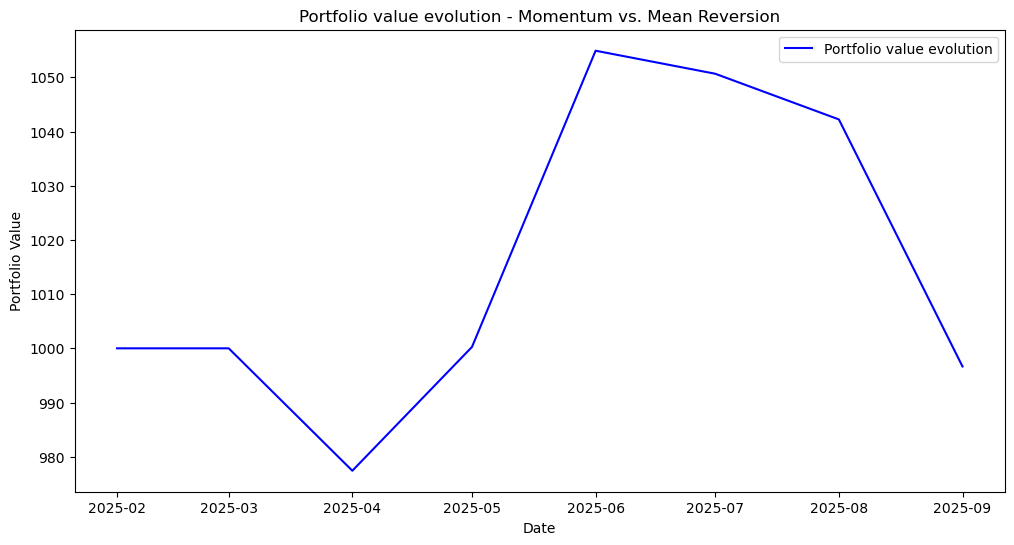

In [46]:
# plotting portfolio value over the next 7/8 months
plt.figure(figsize = (12, 6))
plt.plot(forward_vix_slope['Period'], portfolio_value, label = 'Portfolio value evolution', color = 'blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio value evolution - Momentum vs. Mean Reversion')
plt.legend()
plt.show()

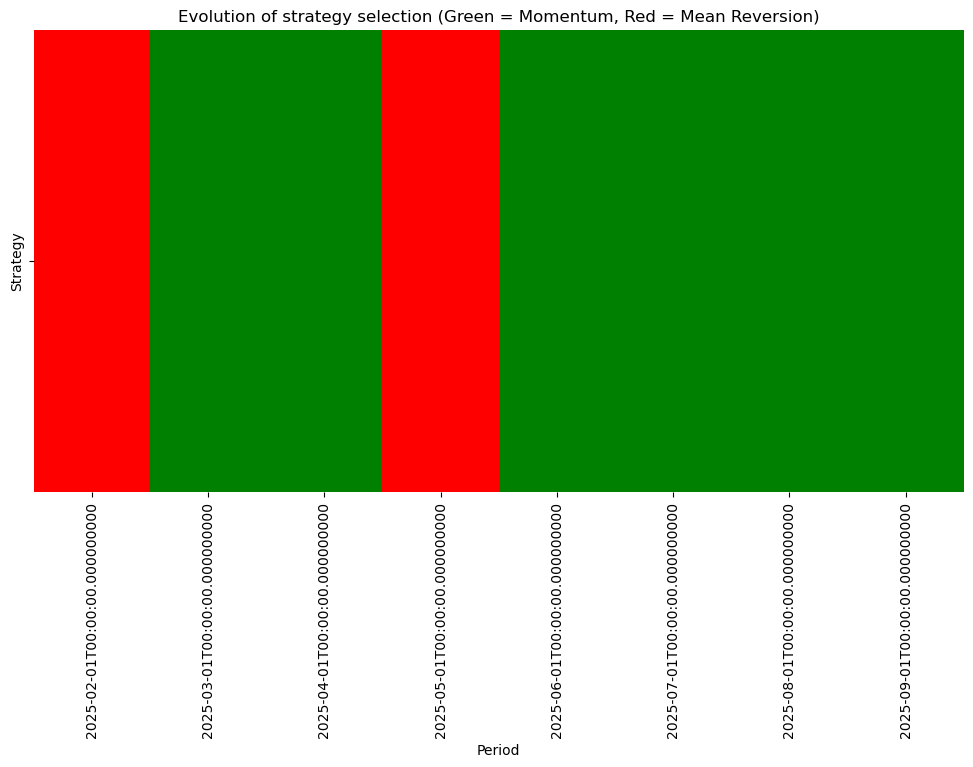

In [47]:
plt.figure(figsize = (12, 6)) # plotting the table with strategy selection
sns.heatmap(pd.DataFrame(strategy_type, index = forward_vix_slope['Period'], columns = ['Strategy']).T == "Momentum", 
            cmap = ['red', 'green'], cbar = False)
plt.title("Evolution of strategy selection (Green = Momentum, Red = Mean Reversion)")
plt.show()

# **Step 4: Backtesting**